### Notebook for the manifold generation of snRNA-Seq mouse data using `bbknn+scanpy`

- **Developed by:** Carlos Talavera-López Ph.D
- **Institute of Systems Immunology (WüSI) - JMU-Würzburg**
- v230828

### Import required modules

In [1]:
import bbknn
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from pywaffle import Waffle
import matplotlib.pyplot as plt

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/umap/distanc

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.2
scanpy      1.9.5
-----
PIL                 10.0.0
annoy               NA
asttokens           NA
backcall            0.2.0
bbknn               1.6.0
colorama            0.4.6
comm                0.1.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
exceptiongroup      1.1.3
executing           1.2.0
h5py                3.9.0
igraph              0.10.8
importlib_resources NA
ipykernel           6.25.1
ipywidgets          8.1.0
jedi                0.19.0
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.1
llvmlite            0.40.1
louvain             0.8.1
matplotlib          3.7.2
mpl_toolkits        NA
natsort             8.4.0
numba               0.57.1
numexpr             2.8.7
numpy               1.24.4
packaging           23.1
pandas              2.1.1
parso               0.8.3
patsy               0.5.3
pexpect             4.8.0
pickleshare     

### Read in all data

In [3]:
adata = sc.read_h5ad('../data/heart_mm_nuclei-23-0092_QCed_ctl230828.raw.h5ad')
adata

AnnData object with n_obs × n_vars = 351093 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [4]:
adata.obs['genotype'].value_counts()

genotype
WT         137028
Mdx        128313
MdxSCID     85752
Name: count, dtype: int64

### Use `sqrt_norm` counts for analysis

In [5]:
adata_raw = adata.copy()
adata.X = adata.layers['sqrt_norm'].copy()

### Calculate Highly Variable Genes

In [6]:
adata.layers['counts'] = adata_raw.X.copy()

In [7]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "sample",
    subset = True
)
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 351093 × 7000
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'sample_colors', 'hvg'
    layers: 'counts', 'sqrt_norm'

### Calculate graph

In [8]:
sc.pp.pca(adata, n_comps = 50, use_highly_variable = True, svd_solver = 'arpack', random_state = 1712)
sc.pp.neighbors(adata, use_rep = "X_pca", n_neighbors = 50, metric = 'minkowski', random_state = 1786)
bbknn_sample = bbknn.bbknn(adata, neighbors_within_batch = 4, batch_key = 'sample', approx = True, copy = True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:42)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:51)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:32)


computing UMAP


/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:35)


/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:12

KeyError: 'percent_chrY'

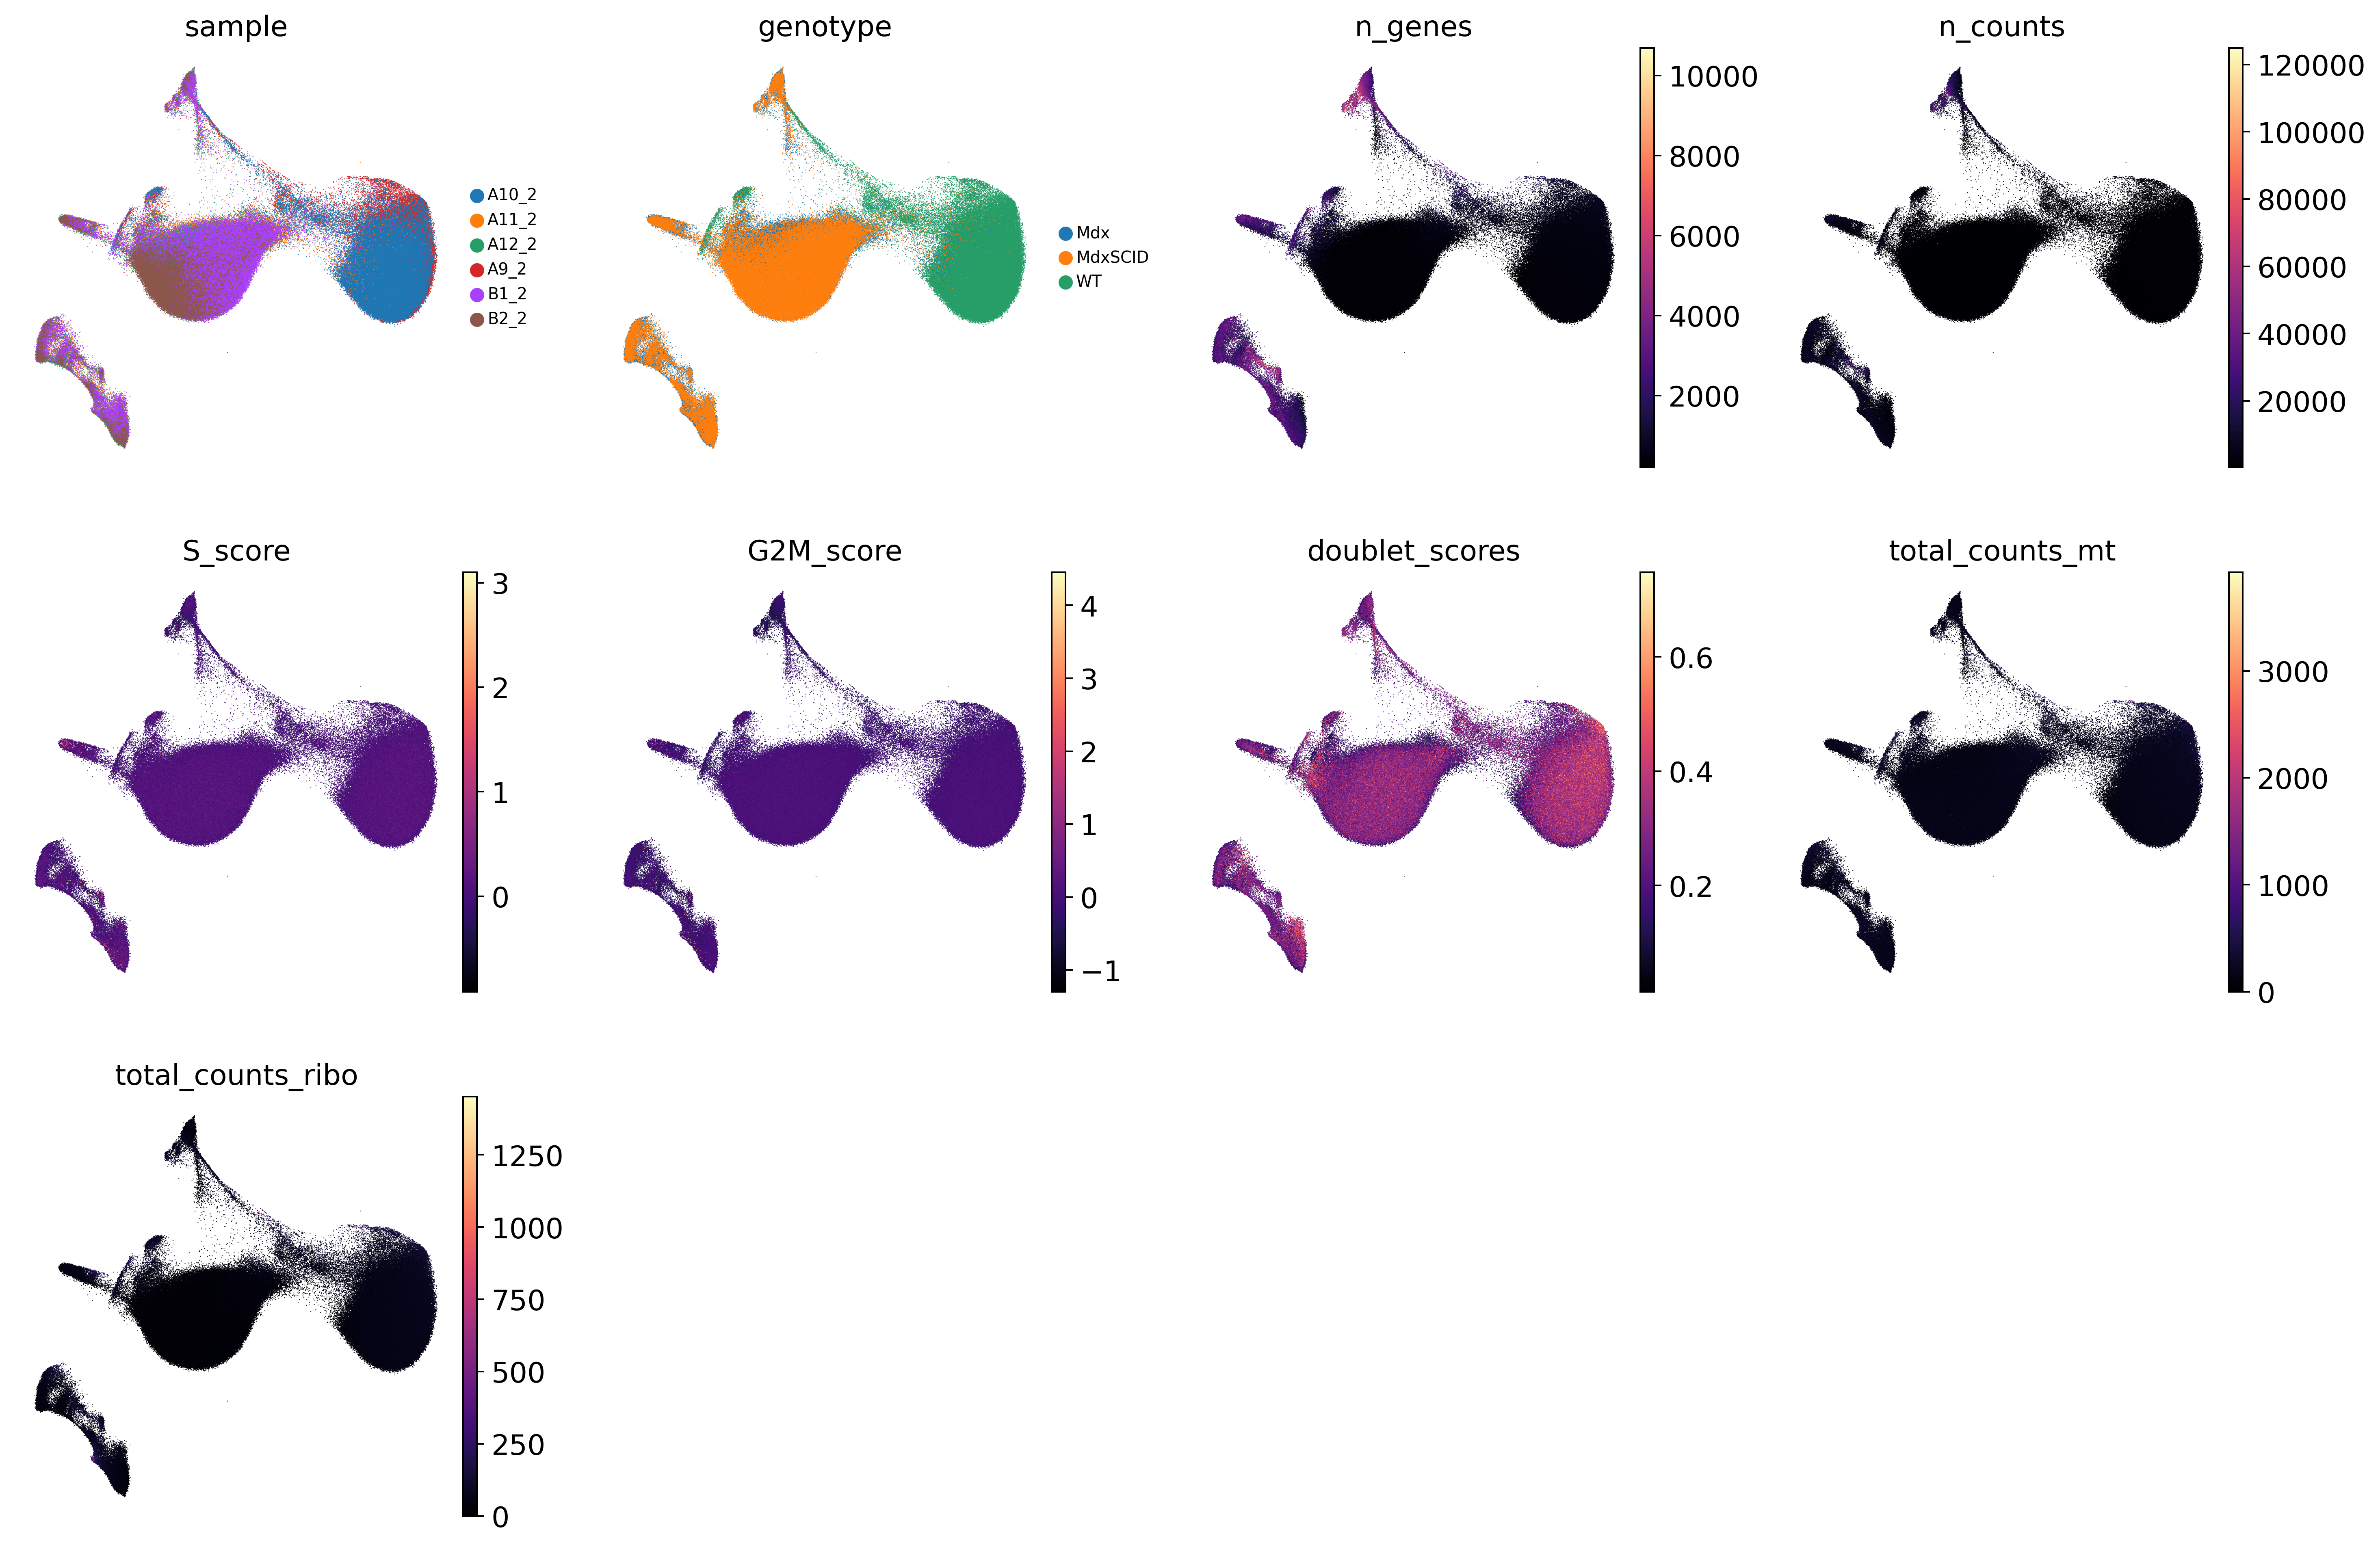

In [9]:
sc.tl.umap(bbknn_sample, min_dist = 0.3, spread = 4, random_state = 1789)
sc.pl.umap(bbknn_sample, frameon = False, color = ['sample', 'genotype', 'n_genes', 'n_counts', 'S_score', 'G2M_score', 'doublet_scores', 'total_counts_mt', 'total_counts_ribo'], size = 0.8, legend_fontsize = 8, ncols = 4)

In [ ]:
sc.pl.umap(bbknn_sample, frameon = False, color = ['sample', 'genotype', 'Ttn', 'Nppa', 'Dcn', 'Vwf', 'Myh11', 'Rgs4', 'Kcnj8', 'C1qa', 'Cd3e', 'Trem2', 'Adipoq', 'Nrxn1', 'Msln'], size = 0.6, legend_fontsize = 8, ncols = 4, cmap = 'magma')

### Visualise co-variate distribution per sample

In [ ]:
sns.set(style="whitegrid")
covariate_to_visualize = 'doublet_scores'

plt.figure(figsize=(10, 6))
sns.histplot(data=adata.obs, x=covariate_to_visualize, hue='sample', stat='count', common_norm=False)
plt.xlabel(covariate_to_visualize)
plt.ylabel('Abundance')
plt.title(f'Abundance Plot of {covariate_to_visualize} by Sample')
plt.legend(title='Sample', loc='upper right')

plt.show()

In [ ]:
sns.set(style="whitegrid")
covariate_to_visualize = 'doublet_scores'

sample_names = adata.obs['sample'].unique()
num_samples = len(sample_names)
color_palette = sns.color_palette("Set1", n_colors=num_samples)

g = sns.FacetGrid(adata.obs, col="sample", col_wrap=3, height=5, palette=color_palette)
g.map_dataframe(sns.histplot, x=covariate_to_visualize, stat='count', common_norm=False)

g.set_axis_labels(covariate_to_visualize, 'Abundance')
g.set_titles(col_template="{col_name}")
g.add_legend(title='Sample', loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
sns.set(style = "whitegrid")
covariate_to_visualize = 'n_counts'

plt.figure(figsize = (10, 6))
sns.histplot(data = adata.obs, x = covariate_to_visualize, hue = 'sample', stat = 'count', common_norm = False)
plt.xlabel(covariate_to_visualize)
plt.ylabel('Abundance')
plt.title(f'Abundance Plot of {covariate_to_visualize} by Sample')
plt.legend(title = 'Sample', loc = 'upper right')

plt.show()

In [ ]:
sample_names = adata.obs['sample'].unique()

# Calculate the number of rows and columns for the subplot layout
num_rows = 2
num_cols = 3

# Create a single figure with multiple panels arranged in a grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Flatten the axs array to make it easier to iterate
axs = axs.flatten()

# Define a color palette for the lines
color_palette = plt.cm.get_cmap('tab10')

# Loop through each sample and generate the UMI count plot in a separate panel
for idx, sample_name in enumerate(sample_names):
    # Select cells belonging to the current sample
    mask = adata.obs['sample'] == sample_name
    sample_adata = adata[mask].copy()

    # Sort cells by UMI counts in descending order
    sample_adata.obs['umi_counts'] = sample_adata.X.sum(axis=1)
    sample_adata = sample_adata[sample_adata.obs['umi_counts'].argsort()[::-1]]

    # Generate the UMI count plot in the current panel
    ax = axs[idx]
    color = color_palette(idx)
    ax.plot(range(1, len(sample_adata) + 1), sample_adata.obs['umi_counts'], marker='o', linestyle='-', label=sample_name, color=color, linewidth=1)
    ax.set_xlabel('Cell Rank')
    ax.set_ylabel('UMI Count')
    ax.set_title(f'UMI Count per Cell for Sample: {sample_name}')
    ax.set_xlim(0, 75000)
    ax.set_ylim(0, 1500)  # Set x-axis limit
    ax.legend()

# Adjust layout and save the figure
plt.tight_layout()
output_filename = 'umi_count_subplot.png'
plt.savefig(output_filename)

# Show the figure
plt.show()
